# Detecting Drivers of Anomalous Backscattering with Multiple Regression 

This notebooks show the application of regression analysis on big EO datasets. In this study we want to better understand the causes of "anomalous" backscattering of Sentinel-1 microwaves from soils. Anomalous backscattering contrasts with the situation where microwaves recorded by Sentinel-1 sensors are governed by the soil's moisture content. The latter "normal" backscattering behavior is governed by the dielectric contrast at the air--soil interface in wet soils [1]. The cause of anomalous backscattering is less well-known but is generally thought to relate to deeper penetration of microwaves in dry soils and volume scattering effects by the presence of rocks or distinct horizons in soils [2, 3].

Hence we want to identify what factors might cause "anomalous" backscattering and we do this by applying a regression model to `rsub` (a metric for anomalous backscattering of Sentinel-1) and a set of soil characteristics.

In [14]:
%matplotlib inline

from IPython.display import display, Math
from pathlib import Path

import numpy as np
import pandas as pd
import dask.dataframe as dd

from sklearn.linear_model import SGDRegressor
from dask_ml.wrappers import Incremental

from pandas.api.types import CategoricalDtype
from dask_ml.preprocessing import Categorizer, DummyEncoder, PolynomialFeatures

import datashader as ds
from datashader.mpl_ext import dsshow
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

## Loading Dask Dataframe

For this analysis we want to explain the causes of anomalous backscattering quantified with the metric `rsub` at 20 meter resolution [4]. This is a temporal correlation between Sentinel-1 backscatter timeseries and reference soil moisture data from [ERA5Land](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land) provided by the European Center for Medium-Range Weather Forecasts (ECMWF) at 9 km resolution. In an attempt to explain anomalies in backscatter data we use the long term dryness of soils (`sm`) as measured by the mean soil moisture content over the last 30 years based on ERA5Land soil moisture data and the coarse fragment content of the soil from the Soil and Landscape Grid of Australia ([SLGA](https://esoil.io/TERNLandscapes/Public/Pages/SLGA/index.html)) at a 90 meter resolution.

The data is derived from a strip along the 21 southern latitude (close to tropic of capricorn 23 S, Figure 1) spanning all the way from the western to the eastern most part of Australia, thereby covering climatic zones from wet at the coast and dry in the interiors of Australia (Figure 1).

![](https://www.yourhome.gov.au/sites/default/files/inline-images/PD_Design_Climate_2.png)

*Figure 1: Australian climate zones (Source: [yourhome.gov.au](https://www.yourhome.gov.au/sites/default/files/inline-images/PD_Design_Climate_2.png)). See website for legend of climate zones.*

This data has already been collected in a Parquet data structure and can be lazily loaded, like so:

In [15]:
soil_df = dd.read_parquet("/data/S1_ERA5L_SLGA")
soil_df

,x,y,depth,rsub,des,cfg,cly,slt,snd,sof,sm
npartitions=130,,,,,,,,,,,
,float32,float32,string,float32,float32,int8,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


The data is partitioned into 10 partitions per Equi7Grid tile [5] and only loaded into memory when explicitly required. For example, when viewing the first 5 observations with `head`.

In [16]:
soil_df.head()

,x,y,depth,rsub,des,cfg,cly,slt,snd,sof,sm
0,114.209999,-28.140833,000_005,0.0168,0.59,1,7.0,4.0,89.0,7.40,0.234107
1,114.209999,-28.140833,005_030,0.0168,0.59,1,8.0,4.0,88.0,3.05,0.220454
2,114.209999,-28.141666,000_005,0.3357,0.62,1,7.0,4.0,89.0,8.20,0.234107
3,114.209999,-28.141666,005_030,0.3357,0.62,1,7.5,4.0,88.0,3.05,0.220454
4,114.209999,-28.144167,000_005,0.1730,0.56,1,6.0,4.0,91.0,12.40,0.234107


The SLGA soil variables are:

- cfg: coarse fragments
- cly: clay content in percent
- slt: silt content in percent
- snd: sand content in percent
- sof: soil organic content in percent

The variable coarse fragments have four ordinal categories:

- very few (0-2%)
- few (2-10%)
- common (10-20%)
- many (20-50%)
- abundant (50-90%)
- very abundant (>90%)

This will be recast to four categories, 

In [17]:
CFG_CATS = dict(
    zip(
        range(1, 7), 
        ["very few (0-2%)", "few (2-10%)", "common (10-20%)", "many (>20%)", 
         "many (>20%)", "many (>20%)"]
        )
    )
CFG_CATS

{1: 'very few (0-2%)',
 2: 'few (2-10%)',
 3: 'common (10-20%)',
 4: 'many (>20%)',
 5: 'many (>20%)',
 6: 'many (>20%)'}

as the upper two level only account for <1% of the total count.

In [18]:
soil_df["cfg"].value_counts(normalize=True).compute() * 100

cfg
2    17.847968
5     8.143097
1    39.347682
6     0.000007
3    13.100854
4    21.560392
Name: proportion, dtype: float64



The values of the soil depth dimension are as follows:

- 0: 0--5 cm depth
- 1: 5--30 cm depth

## Visualize Data

First let's have a look at some of the data. We plot here the anomaly detection metric `rsub` and the coarse fragments content of the upper layer.

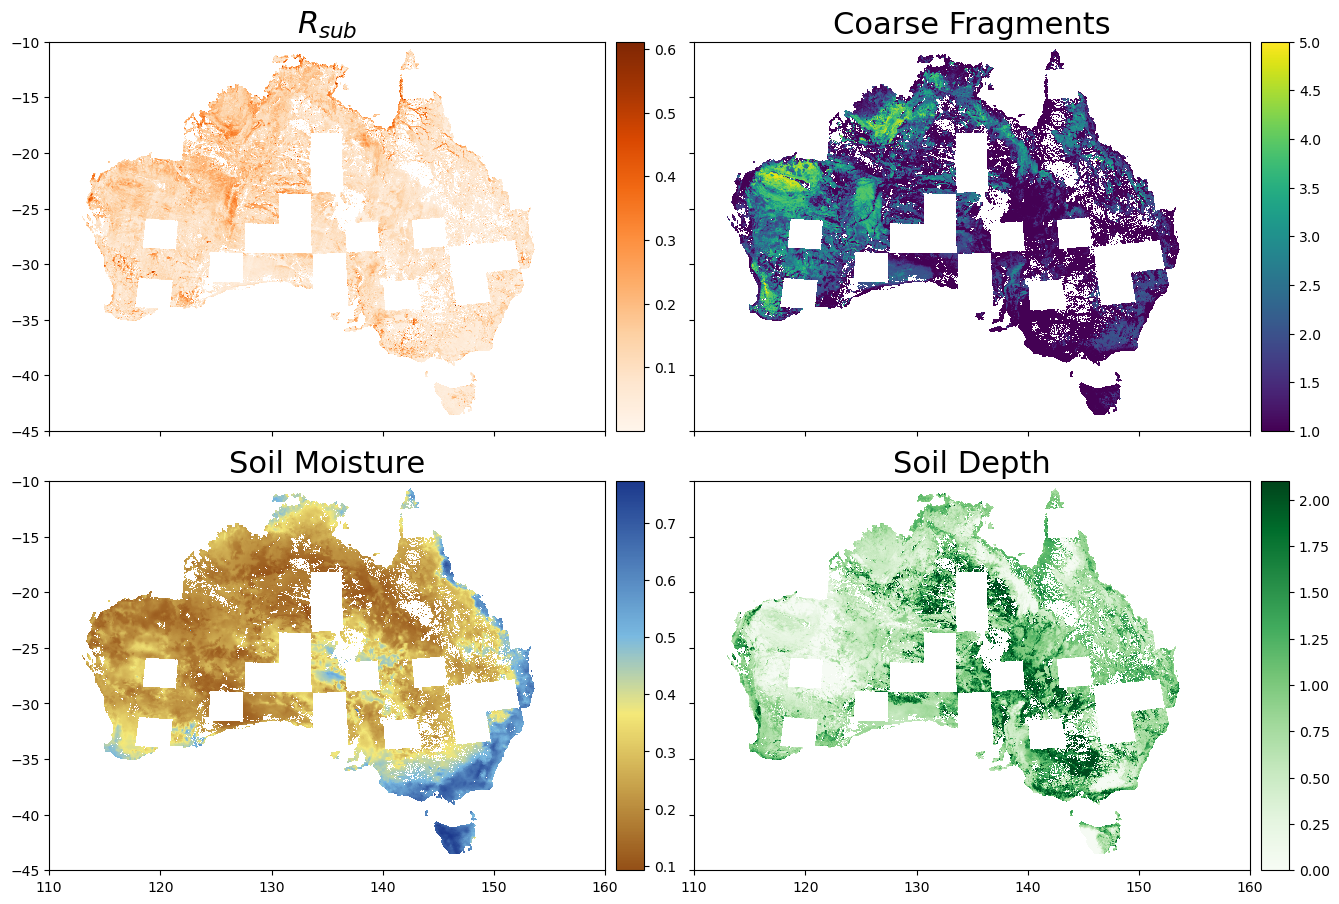

In [19]:
fig = plt.figure(figsize=(16, 16))

def load_cmap(file: Path) -> LinearSegmentedColormap:
    def to_hex_str(c_str: str) -> str:
        r_s, g_s, b_s = c_str.split()
        return f"#{int(r_s):02x}{int(g_s):02x}{int(b_s):02x}"

    ct_lines = Path(file).read_text().splitlines()
    brn_yl_bu_colors = [to_hex_str(clr_str) for clr_str in ct_lines[:200]]
    return matplotlib.colors.LinearSegmentedColormap.from_list("", brn_yl_bu_colors)

SSM_CMAP = load_cmap("data/colour-tables/ssm-continuous.ct")

grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.5, share_all=True,
                 cbar_location="right", cbar_mode="each", cbar_size="5%", cbar_pad="2%")

art0 = dsshow(soil_df[soil_df.depth=="000_005"], ds.Point('x', 'y'), ds.mean("rsub"), cmap="Oranges", x_range=[110,160], y_range=[-45,-10], ax=grid[0])
grid[0].set_title("$R_{sub}$", fontsize=22)
plt.colorbar(art0, cax=grid.cbar_axes[0])

art1 = dsshow(soil_df[soil_df.depth=="000_005"], ds.Point('x', 'y'), ds.mean("cfg"), cmap="viridis", x_range=[110,160], y_range=[-45,-10], ax=grid[1])
grid[1].set_title("Coarse Fragments", fontsize=22)
plt.colorbar(art1, cax=grid.cbar_axes[1])

art2 = dsshow(soil_df[soil_df.depth=="000_005"], ds.Point('x', 'y'), ds.mean("sm"), cmap=SSM_CMAP, x_range=[110,160], y_range=[-45,-10], ax=grid[2])
grid[2].set_title("Soil Moisture", fontsize=22)
plt.colorbar(art2, cax=grid.cbar_axes[2])

art3 = dsshow(soil_df[soil_df.depth=="000_005"], ds.Point('x', 'y'), ds.mean("des"), cmap="Greens", x_range=[110,160], y_range=[-45,-10], ax=grid[3])
grid[3].set_title("Soil Depth", fontsize=22)
plt.colorbar(art3, cax=grid.cbar_axes[3])

## Data Preprocessing

We will be using a linear regression model, where we want to explain `rsub` with two explanatory variables `sm` and `cfg`. This multiple regression model can be formulated as follows;

$$ rsub = \beta_0 + \beta_1 sm + \beta_2 cfg $$

, where we want to find suitable values for the coefficients $\beta_0$ (or intercept) and the partial slopes $\beta_1$ and $\beta_2$.

In [20]:
EXP_VARIABLES = ["sm", "cfg"]
RES_VARIABLE = "rsub"

For this exercise we will only use the upper depth interval  (0--5 cm) of the soil properties. We therefore filter our Dask Dataframe, as follows:

In [21]:
soil_df = soil_df[soil_df.depth == "000_005"]
soil_df.head()

,x,y,depth,rsub,des,cfg,cly,slt,snd,sof,sm
0,114.209999,-28.140833,000_005,0.0168,0.59,1,7.0,4.0,89.0,7.4,0.234107
2,114.209999,-28.141666,000_005,0.3357,0.62,1,7.0,4.0,89.0,8.2,0.234107
4,114.209999,-28.144167,000_005,0.1730,0.56,1,6.0,4.0,91.0,12.4,0.234107
5,114.210831,-28.145000,000_005,0.0961,0.56,1,6.0,3.0,91.0,7.5,0.234107
6,114.214165,-28.140833,000_005,0.0493,0.59,1,6.0,4.0,90.0,7.8,0.234107


## Dealing with Categories

To include categories in a model we require a conversion to data type that is useable by the algorithm. For this we use dummy encoding, which transforms the categories in each their own column with boolean values for when the category is present.

We first merge the categories to four levels and then turn the cfg into a Pandas CategoricalDtype:

In [22]:
X = soil_df[EXP_VARIABLES]
ca = Categorizer(categories={
    "cfg": CategoricalDtype(list(range(1,5)))
    })
X = ca.fit_transform(X)
X

,sm,cfg
npartitions=130,,
,float32,category[known]
,...,...
...,...,...
,...,...
,...,...


Then we dummy encode cfg:

In [23]:
de = DummyEncoder(["cfg"], drop_first=True)
X = de.fit_transform(X)
X

,sm,cfg_2,cfg_3,cfg_4
npartitions=130,,,,
,float32,bool,bool,bool
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


## Interactions

In the model we would not only be interested in the effect of the single explanatory variables on the response, but also the interactions of e.g. coarse fragments in the soil and the overall wetness of soils. This includes the effect that dry soil allow deeper penetration of microwaves that can results in volume scattering by stone and rock fragments at depth. Hence we have to include an interaction in the regressors of the model, by multiplying `sm` with `cfg`, yielding the following formula:

$$ rsub = \beta_0 + \beta_1 sm + \beta_2 cfg_2 + \beta_3 cfg_3 + \beta_4 cfg_4 + \beta_5 sm \times cfg_2 + \beta_6 sm \times cfg_3 + \beta_7 sm \times cfg_4 $$

which can be implemented, like so:

In [24]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False, preserve_dataframe=True)
X = poly.fit_transform(X)
X

,sm,cfg_2,cfg_3,cfg_4,sm cfg_2,sm cfg_3,sm cfg_4,cfg_2 cfg_3,cfg_2 cfg_4,cfg_3 cfg_4
npartitions=33,,,,,,,,,,
,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


## Modelling with Dask-ML

Now we can start to construct our regression model. Stochastic Gradient Descent (SGD) is a technique that is ideally suited for fitting regression models to large datasets. The method employs the SGD algorithm by iteratively updating model parameters. This means that a model can also be adapted when new data becomes available. For our purpose SGD means that we can iteratively feed the model Dask Dataframe partitions to increasingly optimize the model parameters. The SGD technique is implemented in Scikit-Learn framework and can be extended with `Dask-ML` to work with Dask Dataframes.

We instantiate the `SGDRegressor` and use the wrapper `Incremental` to make it compatible with `Dask` data structures. We score the optimized model with the negative mean squared error, where we maximize this scoring (e.g. we minimize the squared error of the residuals).

In [25]:
model = SGDRegressor()
dask_model = Incremental(model, scoring='neg_mean_squared_error')

Fitting the model occur by `partial_fit` and providing the Dask Dataframe columns containing $sm$, $cfg$, and $sm \times cfg$ as predictors and $rsub$ as the response. The solution is numerically derived so we run the whole model 10 times to ensure the most accurate results.

In [26]:
for i in range(10):
   dask_model.partial_fit(X, soil_df["rsub"])

AssertionError: 

We can visualize the fitted model by extracting the model parameters and injecting these in the formula as defined before.

In [ ]:
form = [r'rsub = {0:.2f}'.format(dask_model.intercept_[0])] + \
  [r'{0:+.2f} {1}'.format(i, nm.split("_")[0]) for nm, i in dict(zip(dask_model.feature_names_in_ , dask_model.coef_)).items() if i !=0]
display(Math("".join(form)))

We can also check how much variance in the response is explaimned by this model. We first have to predict the response given the regressors (`sm`, `cfg`, and `sm x cfg`), like so:

In [ ]:
predict = dask_model.predict(X)

Then we plot the predicted values against the observed values.

In [ ]:
soil_df["predict"] = predict
soil_df.persist()
dsshow(soil_df, ds.Point('rsub', 'predict'), norm='eq_hist', cmap="inferno_r", x_range=[-1,1], y_range=[-1,1])

This so-called R2 plot show the real variance of `rsub` offset against the predicted `rsub`.

## Predictor Effect Plot

Predictor effect plots are visual tool to understand more complex models that are not readily interpretable by looking at summaries of tables on coefficients, standard errors, and test statistics. It is a great tool to disentangle a model main effect from interacting effects, such as our model. The predictor effect plot works by using partial fits of the full regression model, where one focal explanatory variable is conditions on fixed values for the remaining explanatory values. In the case of our model a partial fit could be the predicted `rsub` values for `sm` and looking only at `cfg` level 1.

Let's now construct a predictor effects plots with partial fits of the regression model to investigate the effect of the individual regressors on the response `rsub`. We first have to create some dummy data to predict the response given a single regressor while keeping the other regressors fixed.

In [ ]:
def make_new_data(target, fixed, num=2):
    vals = list(*target.values())
    df = pd.DataFrame({list(target.keys())[0]: np.linspace(vals[0], vals[1], num=num*2, endpoint=True, dtype=vals[0].dtype)})
    for name, value in fixed.items():
        df[name] = np.repeat(value, repeats=num*2)
    return df

This data can then be fed to the original model, like so:

In [ ]:
def partial_fit_(target, fixed, model):
    X = make_new_data(target, fixed)
    new_df = X
    X["cfg"] = X["cfg"].replace(cfg_cats)
    ca = Categorizer(categories={"cfg": CategoricalDtype(list(cfg_cats.values())[:4])})
    X = ca.fit_transform(X)
    de = DummyEncoder(["cfg"], drop_first=True)
    X = de.fit_transform(X)
    poly = PolynomialFeatures(interaction_only=True, include_bias=False, preserve_dataframe=True)
    X = poly.fit_transform(X)
    X = X.iloc[:,:-3]
    new_df["predict"] = model.predict(X)
    return new_df

def expand_grid(fixed):
     return dict(
         zip(fixed.keys(), 
         list(map(np.ravel, np.meshgrid(*fixed.values()))))
        )

def partial_fit(target, fixed, model):
    fitted_data = []
    fixed_expanded = expand_grid(fixed)
    for i in range(np.array([*fixed_expanded.values()]).shape[1]):
        fitted_data.append(partial_fit_(target, {k:v[i] for k,v in fixed_expanded.items()}, model))
    return pd.concat(fitted_data)

Applying these functions and fixing `sm` to five distinct values (i.e. five quantiles of variable in this case), we obtain the following results. Here we plot the predicted `rsub` given `cfg` for the five values of `sm` on which the partial fit was conditioned.

In [ ]:
partial_sm = partial_fit(
    {"cfg": (np.int8(1), np.int8(4))}, 
    {
        "sm": [0.025, 0.125, 0.25]
    }, 
    dask_model
)

In [ ]:
g = sns.FacetGrid(partial_sm, col='sm', sharex=False, margin_titles=True, height=4)
g = g.map(sns.pointplot,'cfg','predict', "sm", palette='deep', order=list(cfg_cats.values())[:4], hue_order=None)
g.set_titles(col_template = 'Soil moisture ($ \\theta$) = {col_name}')
g.set(ylabel="$\\hat{R}_{sub}$", xlabel="")
g.set_xticklabels(rotation=60)

Evaluating the plots above seems to suggest that anomalous data is more prevalent under drier soil conditions with an elevated coarse fragment content. This relationship seems to shrink at higher levels of soil moisture.

## References

[1] W. Wagner, G. Lemoine, and H. Rott, “A Method for Estimating Soil Moisture from ERS Scatterometer and Soil Data,” Remote Sensing of Environment, vol. 70, no. 2, pp. 191–207, Nov. 1999, doi: 10.1016/S0034-4257(99)00036-X.    

[2] K. Morrison and W. Wagner, “Explaining Anomalies in SAR and Scatterometer Soil Moisture Retrievals From Dry Soils With Subsurface Scattering,” IEEE Trans. Geosci. Remote Sensing, vol. 58, no. 3, pp. 2190–2197, Mar. 2020, doi: 10.1109/TGRS.2019.2954771.    

[3] W. Wagner et al., “Widespread occurrence of anomalous C-band backscatter signals in arid environments caused by subsurface scattering,” Remote Sensing of Environment, vol. 276, p. 113025, Jul. 2022, doi: 10.1016/j.rse.2022.113025    

[4] B. Raml, M. Vreugdenhil, S. Massart, C. Navacchi, and W. Wagner, “ENABLING GLOBAL SCALE SENTINEL-1 TIME SERIES ANALYSIS THROUGH STREAMING”.    

[5] B. Bauer-Marschallinger, D. Sabel, and W. Wagner, “Optimisation of global grids for high-resolution remote sensing data,” Computers & Geosciences, vol. 72, pp. 84–93, Nov. 2014, doi: 10.1016/j.cageo.2014.07.005.
